In [4]:
%pylab inline

import pandas as pd
import pickle
import requests
import quandl

rcParams["axes.grid"] = True
rcParams["figure.figsize"] = (12,8)

Populating the interactive namespace from numpy and matplotlib


In [5]:
quandl.ApiConfig.api_key = 'N3w6_c4owXgqRFxkzZMc'

In [6]:
def FESX(expiry):
    month = {6:'M', 3:'H', 9:'U', 12:'Z'}
    dated = datetime.datetime.strptime(expiry,'%Y-%m-%d')
    return 'FESX%s%d'%(month[dated.month],dated.year)

In [7]:
df = pd.DataFrame()
expiries = ['2019-06-21','2019-03-15',
            '2018-12-21','2018-09-21','2018-06-15','2018-03-16',
            '2017-12-15','2017-09-15','2017-06-16','2017-03-17',
            '2016-12-16','2016-09-16','2016-06-17','2016-03-18',
            '2015-12-18','2015-09-18','2015-06-19','2015-03-20',
            '2014-12-19','2014-09-19','2014-06-20','2014-03-21',
            '2013-12-20','2013-09-20'][::-1]
previous = [datetime.datetime.strptime(expiry,'%Y-%m-%d')-datetime.timedelta(days=1) for expiry in expiries]
futures = [FESX(expiry) for expiry in expiries]

In [8]:
prices = pd.Series()
for idx in range(1,len(futures)):
    fut = futures[idx]
    prices = prices.append(quandl.get('EUREX/%s'%fut, start_date=expiries[idx-1], end_date=previous[idx]).Settle)

In [179]:
# Get dividend futures with expiries Dec2014 to Dec2024 from launch (2013-09-09) to present
div_futures = ['FEXDZ%d'%(year+2014) for year in range(11)]
# Specify which of these would be the "4y" future, i.e. expiring december in year + 4
futures4y = [div for div in div_futures if int(div[-4:]) >= 2017]
expired = [div for div in div_futures if int(div[-4:]) < 2019]
divs = {}
for div in div_futures:
    divs[div] = quandl.get('EUREX/%s'%div, start_date='2013-09-09', end_date='2019-05-31').Settle 

In [190]:
# Prices for a future 4y prior to expiry. For ex: the Z20 future will show prices in 2016  
entry = {div: divs[div]['%s-01-01'%(int(div[-4:])-4):'%s-12-31'%(int(div[-4:])-4)] for div in futures4y}
# Build the "continous 4y" future
cont4y = pd.Series()
for div in futures4y:
    cont4y = cont4y.append(entry[div])
cont4y = pd.Series([divs['FEXDZ%d'%(idx.year+4)][idx]*(datetime.datetime(idx.year,12,31) - idx).days/365 +
                    divs['FEXDZ%d'%(idx.year+5)][idx]*(365 - (datetime.datetime(idx.year,12,31) - idx).days)/365 
                    for idx in cont4y.index],index=cont4y.index)

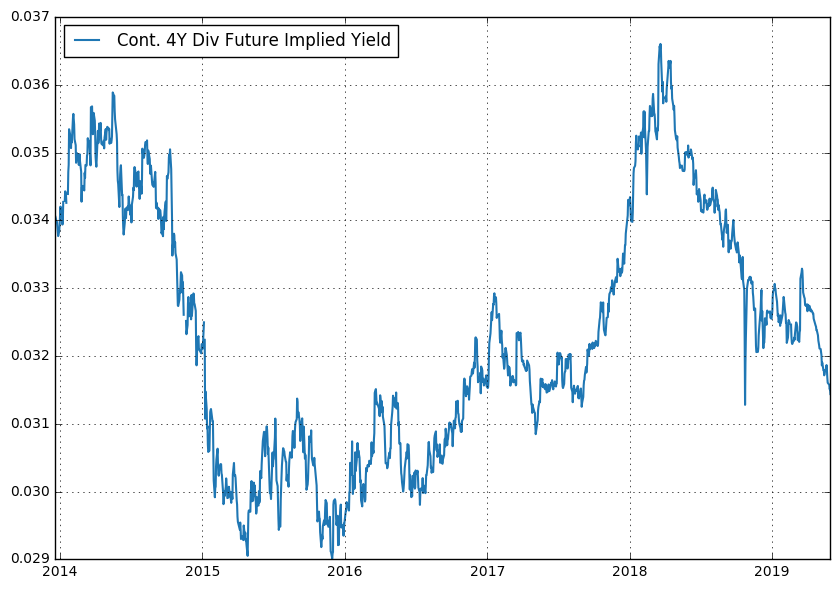

In [192]:
plot(cont4y/prices, label='Cont. 4Y Div Future Implied Yield')
legend(loc='upper left')

In [238]:
settlements = [divs[div].iloc[-1] for div in expired]

In [231]:
# Premium collected by buying and holding 4y future from given date
premium = pd.Series()
delta   = pd.Series()
for div in expired:
    if div not in futures4y:
        continue
    premium = premium.append(divs[div][divs[div].index[-1]] - entry[div])
    delta = delta.append(prices[divs[div].index[-1]] - prices[entry[div].index])

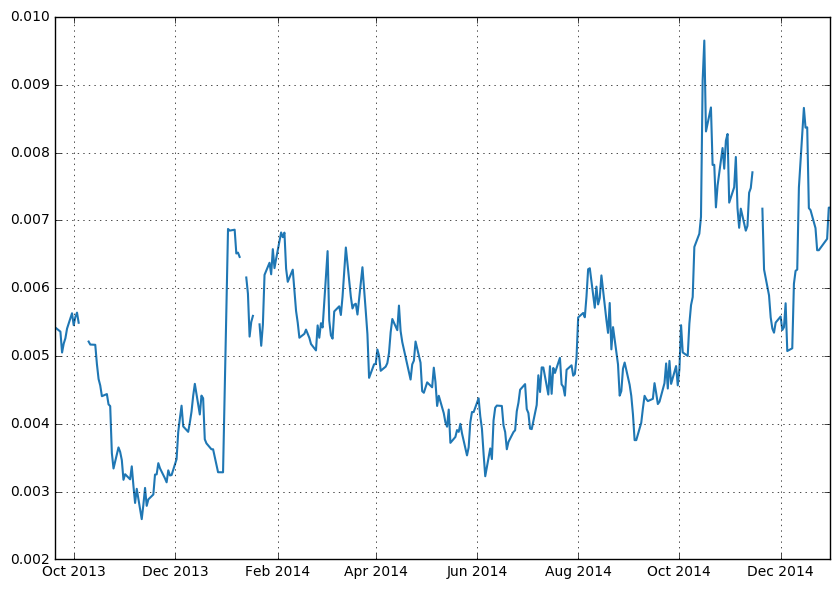

In [240]:
plot(premium/prices)

(735120.0, 735598.0)

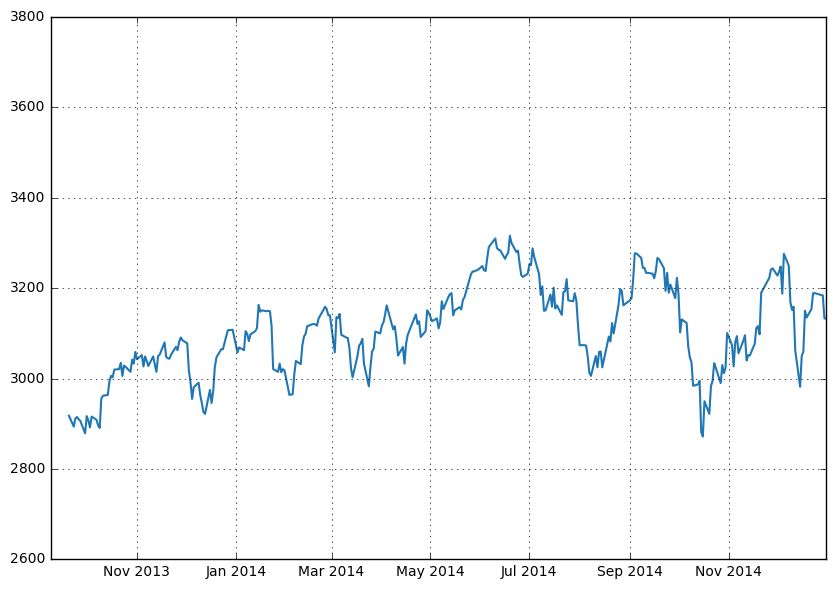

In [237]:
plot(prices)
xlim(premium.index[0],premium.index[-1])